# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

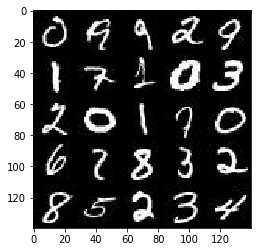

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

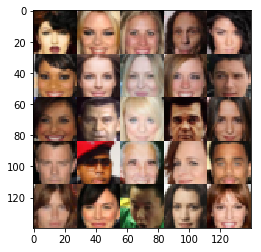

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import numpy as np
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #leaky relu hyperparameter
    alpha = 0.2
    #droupout hyperparameter
    drop_rate = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #28x28
        conv = tf.layers.conv2d(images, 128, 5, strides=4, padding='same')
        conv = tf.maximum(alpha * conv, conv) #leaky relu allows gradient to flow
        conv = tf.layers.dropout(conv, drop_rate, training=True) #improves generalization and gets generator a chance to learn
        #print(conv.get_shape().as_list())
        
        #7x7x128
        conv = tf.layers.conv2d(conv, 256, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.layers.dropout(conv, drop_rate, training=True) #improves generalization and gets generator a chance to learn
        #print(conv.get_shape().as_list())
        
        #layer removed in order to make the discriminator less expressive (giving advantage to generator)
        #conv = tf.layers.conv2d(conv, 512, 4, strides=2, padding='same')
        #conv = tf.layers.batch_normalization(conv, training=True)
        #conv = tf.maximum(alpha * conv, conv)
        #conv = tf.layers.dropout(conv, drop_rate, training=True)
        #print(conv.get_shape().as_list())
     
        #4x4x256
        flatten_shape = np.prod(conv.get_shape().as_list()[1:])
        flatten = tf.reshape(conv, [-1, flatten_shape])
        #print("Flatten shape: {}".format(flatten_shape))
    
        #classifier
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #leaky relu hyperparameter
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        z = tf.layers.dense(z, 4*4*512, 
                            use_bias=False,
                            activation=None)
        z = tf.reshape(z, [-1, 4, 4, 512])
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.maximum(alpha * z, z)
        
        #print(z.get_shape().as_list())
        
        #4x4x512
        conv = tf.layers.conv2d_transpose(z, 256, 4, strides=1, padding='valid',
                                          use_bias=False,
                                          activation=None)
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        #print(conv.get_shape().as_list())

        
        #7x7x256
        conv = tf.layers.conv2d_transpose(conv, 128, 5, strides=2, padding='same',
                                          use_bias=False,
                                          activation=None)
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        #print(conv.get_shape().as_list())
        
        #14x14x128
        conv = tf.layers.conv2d_transpose(conv, out_channel_dim, 5, strides=2, padding='same',
                                          use_bias=False,
                                          activation=None)
        #print(conv.get_shape().as_list())
           
    return tf.nn.tanh(conv)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake))
                           )
    
    #avoiding 1's for real logits, we have to reduce these to allow generator to improve
    label_smoothing = 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * label_smoothing)
                           )
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake))
                           )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #retrieving trainable vars
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #getting update ops for each one
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_update_ops = [op for op in update_ops if op.name.startswith('discriminator')]
    g_update_ops = [op for op in update_ops if op.name.startswith('generator')]
    
    #
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    #image mode
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1

    #inputs, loss models and optmizers
    input_real, input_z, lr = model_inputs(*(data_shape[1:]), z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    ##
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                #generate random sample
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #images are in range [-0.5, 0.5], changing to [-1, 1]
                batch_images *= 2.0
                
                #compute loss
                _ = sess.run(d_train_opt, feed_dict={input_z: z, 
                                                     input_real: batch_images, 
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: z,
                                                     lr: learning_rate})
                
                #print outs
                if step % 25 == 0:
                    train_loss_d = d_loss.eval({input_z: z,
                                                input_real: batch_images,
                                                lr: learning_rate})
                    
                    train_loss_g = g_loss.eval({input_z: z,
                                                lr: learning_rate})

                    #print losses
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if step % 500 == 0:
                    #print images
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
                
                
            print("End batch")
        print("End epoch")
        
        print("Final images:")
        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
        
    print("End")  
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 2.4012
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 1.0869
Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 1.7365
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 1.6638
Epoch 1/2... Discriminator Loss: 0.7590... Generator Loss: 1.7821
Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 2.6675
Epoch 1/2... Discriminator Loss: 0.4966... Generator Loss: 3.0235
Epoch 1/2... Discriminator Loss: 0.4962... Generator Loss: 3.0782
Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 2.5075
Epoch 1/2... Discriminator Loss: 1.4741... Generator Loss: 0.9504
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 1.2997
Epoch 1/2... Discriminator Loss: 0.9008... Generator Loss: 1.3013
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 0.9788... Generator Loss: 1.2893
Epoch 1/2.

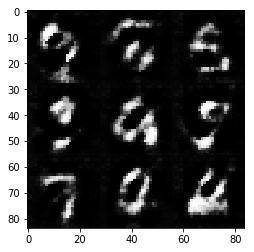

Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 1.2967
Epoch 1/2... Discriminator Loss: 1.1937... Generator Loss: 1.2158
Epoch 1/2... Discriminator Loss: 1.2537... Generator Loss: 0.8184
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 1.3423... Generator Loss: 1.0969
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 1.1737
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 1.0802
Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 0.9458
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 1.1102
Epoch 1/2.

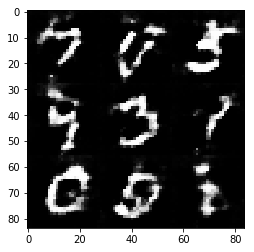

Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 0.9244
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 1.2291
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 1.1168
Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 1.0309
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 0.9452
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 1.0111
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 1.0925... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.8951
Epoch 1/2.

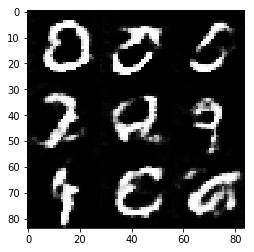

Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 1.1620
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 1.1440
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.9544
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 0.8491
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 1.0797
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 1.0647
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.9102
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 1.0799
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.2748... Generator Loss: 0.9380
End batch


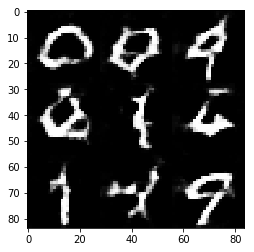

Epoch 2/2... Discriminator Loss: 1.3296... Generator Loss: 1.0406
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 1.0089
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 0.9780
Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.9294
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.9353
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 1.0210
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 1.0688
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 1.1198
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.8668
Epoch 2/2.

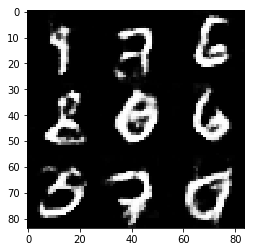

Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.9470
Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.7655
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 0.9745
Epoch 2/2... Discriminator Loss: 1.1368... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.8162
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 1.2915... Generator Loss: 0.9572
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.9029
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 1.0130
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 1.0465
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 1.0479
Epoch 2/2.

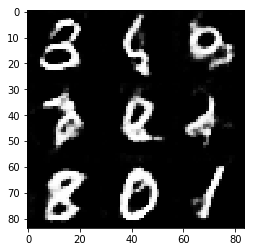

Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.8170
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.9352
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 1.0487
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.9612
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.9645
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.8860
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.9022
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.8922
Epoch 2/2.

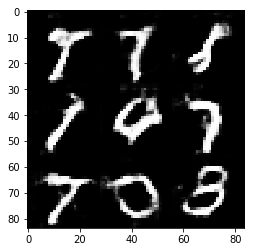

Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 0.9918
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 1.0137
Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 1.2588
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 0.9997
End batch
End epoch
Final images:


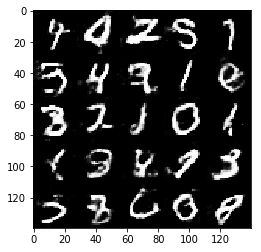

End


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.4596
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.6548
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 3.9736
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.7633
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 3.7728
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 2.0855
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 2.6091
Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 2.7351
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 2.5018
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 2.2111
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.8132
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 2.6190
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 0.4329... Generator Loss: 3.6673
Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 2.5690
Epoch 1/1.

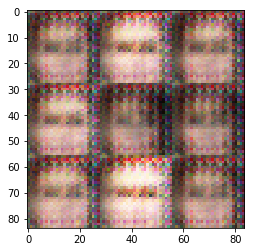

Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.8446
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.4717
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.5528
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.7311
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 2.1470
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.7632
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.8646
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.3809
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 1.4627
Epoch 1/1.

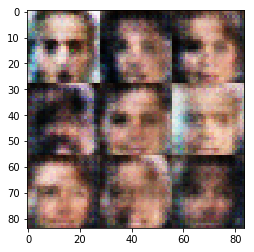

Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.6182
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.6077
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.1120
Epoch 1/1.

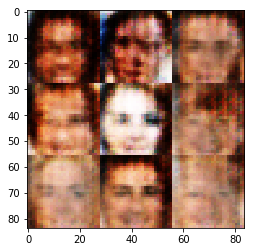

Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 1.4660
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.9192
Epoch 1/1.

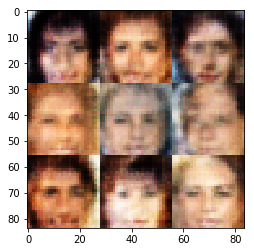

Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.9605
Epoch 1/1.

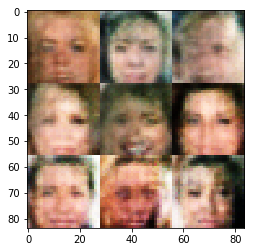

Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8060
Epoch 1/1.

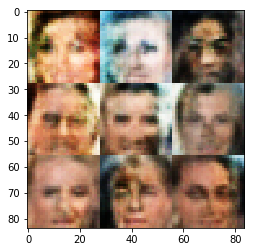

Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.9234
Epoch 1/1.

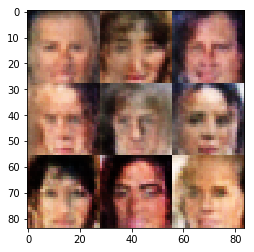

Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8500
Epoch 1/1.

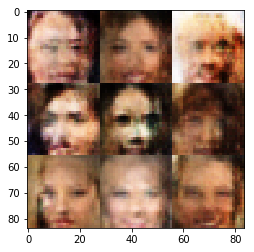

Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.9352
Epoch 1/1.

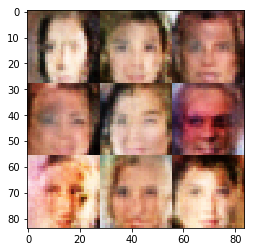

Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8847
Epoch 1/1.

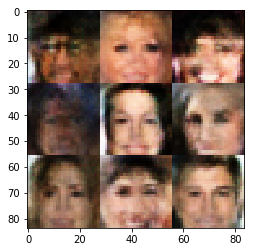

Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7271
Epoch 1/1.

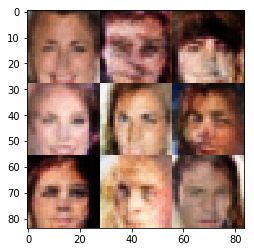

Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8677
Epoch 1/1.

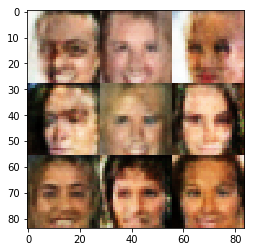

Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7722
End batch
End epoch
Final images:


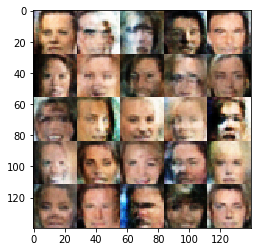

End


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.